In [50]:
import numpy as np
from astropy.io import fits
import astropy.visualization as visz
from astropy.visualization import astropy_mpl_style
import matplotlib.pyplot as plt
from matplotlib import rcParams
import itertools

plt.style.use(astropy_mpl_style)
%matplotlib inline

rcParams['figure.figsize'] = 15, 7
rcParams['lines.markersize'] = 2
rcParams['figure.titlesize'] = 16
rcParams['font.size'] = 14

# Stats on night_1 image difference results 
### 20-11-2017

Stats generated from `stdout` and `stderr` that were piped to file `out`. The rest of files are `greps` of various interesting numbers/parameters/stings from that file to make parsing them easier. Even though there's a `grep` of processed file-names the lines from other files don't follow 1-on-1 correspondence because certain differences failed or because of parallelization certain differences completed before others.

Overall several things were not done properly: 

  1) made a off-by-one error where I image difference same frames     
  2) there are missing data - for some visits certain CCD images are just not there      
  3) missing data - certain visits are missing completely    
  
Missing data is listed in tables at the end of the notebook. 

Overall the observing runs are taken in sequences of non-constant number of pointing's. Sometimes they will follow a pattern where in a sequence they cover 5 neighbouring pointing's and then return and repeat the pointing they started off. This marks the beginning of a new sequence in which they revisit all the previous pointing's. They repeat this from 2 to 6 times. 

Each exposure takes 40 seconds.      
Therefore, for a sequence containing 5 images the time to complete the sequence and revisit the first field is 280 seconds. Because the number of pointing's in a sequence is not constant this number can not be held valid for all revisits.


Even though the x-axis indices can not directly be tied to calexps used, since some image differences failed and/or due to the paralelization have not completed in the order they were executed in, they are comparable between graphs. I.e. index 5000 represents the same image on all graphs shown.

In [51]:
def read_overlap(path):
    tmp = []
    with open(path) as f:
        for line in f.readlines():
            tmpavg = float(line.split(":")[-1].strip())
            tmp.append(tmpavg)
    return np.asarray(tmp)


        
def read_detection_info(path):
    tmp = []
    with open(path) as f:
        for line1,line2 in itertools.zip_longest(*[f]*2):
            #print(line1,line2)
            tmppos = line1.split("Detected")[-1]
            tmppos = int(tmppos.split(" ")[1])
            tmpneg = line2.split("Detected")[-1]
            tmpneg = int(tmpneg.split(" ")[1])
            tmp.append((tmppos, tmpneg))
    return np.asarray(tmp)



def read_merged_num(path):
    tmp = []
    with open(path) as f:
        for line in f.readlines():
            tmpnum = int(line.split(" ")[-2])
            #tmpdet = int(tmpdet.split(" ")[1])
            tmp.append(tmpnum)
    return np.asarray(tmp)



def read_num_sources(path):
    tmp = []
    with open(path) as f:
        for line in f.readlines():
            tmptot = line.split("Measuring ")[-1]
            tmptot = int(tmptot.split(" ")[0])
            tmpparent = line.split("(")[-1]
            tmpparent = int(tmpparent.split(" ")[0])
            tmpchild = line.split(", ")[-1]
            tmpchild = int(tmpchild.split(" ")[0])
            tmp.append((tmptot, tmpparent, tmpchild))
    return np.asarray(tmp)



def read_scalinggrid_param(path):
    tmp = []
    with open(path) as f:
        for line in f.readlines():
            tmpscale = float(line.split(" ")[-1])
            tmp.append(tmpscale)
    return np.asarray(tmp)



def read_subimg_num(path):
    return read_merged_num(path)

# Total Sources, Positive and Negative Dipole Sources

After image differencing step, a source fitting procedure is run. First, dipole sources are fitted for in every image - with no requirements that the counts between the two should match.

There were 967 280 positve and 1 320 913 negative sources found on 21 797 differenced images.
Only a 336 of all processed image differences have more than 100 objects detected on the differenced image, while 1037 (~5%) differenced images had more than 100 negative sources detected on them. Therefore, dipole source fitting shows stabile trends with several interesting outliers.     

These outliers are attributed to poorly calibrated, or just poor in quality, images - usually made by CCD 31.

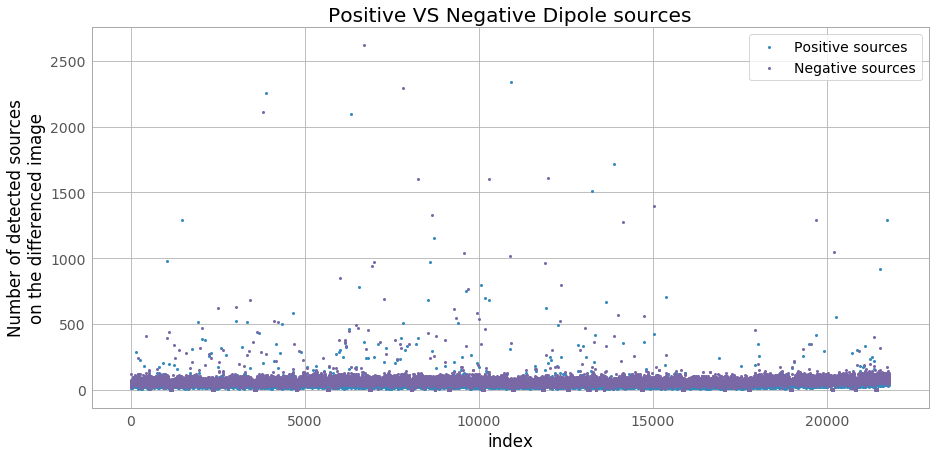

In [43]:
a = read_detection_info("detection_info")
pos, neg = a[:,0], a[:, 1]
x = range(len(a))
plt.scatter(x, pos, label="Positive sources")
plt.scatter(x, neg, label="Negative sources")
plt.legend()
plt.title("Positive VS Negative Dipole sources")
plt.xlabel("index")
plt.ylabel("Number of detected sources\non the differenced image")

In general number of negative sources prevails (see bottom pos-neg graph) - which is to be expected as image differencing leaves black/blank areas where unchanged and successfully differenced objects used to be.  

Appart from unexplained outliers in top graph where some images display only the positive or negative sources there are also noticeable periodical vertical white lines visible in the bottom graph. These, I believe, can be explained (see total number of sources graph).

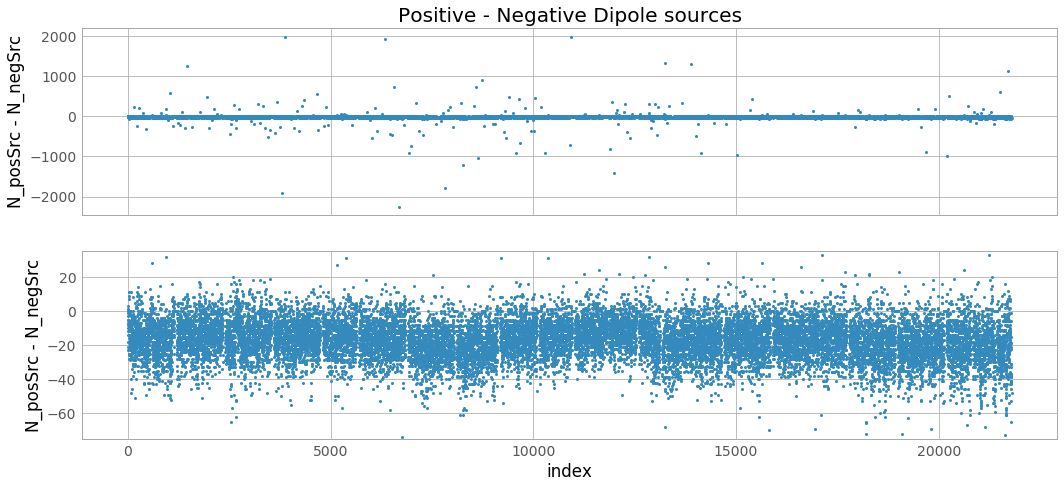

In [44]:
fig, axes = plt.subplots(2, 1, sharex=True)

[ax.scatter(x, a[:,0]-a[:,1]) for ax in axes]

axes[0].set_title("Positive - Negative Dipole sources")
axes[0].set_ylabel("N_posSrc - N_negSrc")
axes[1].set_ylim(-75, 35)
axes[1].set_ylabel("N_posSrc - N_negSrc")
axes[1].set_xlabel("index")
plt.tight_layout()

If possible, positive and negative sources are merged together and stored in diaSrc-##.fits file. I believe that positive and negative sources that could not be matched with each other, or in the case of a negative source could not be matched to a positive source or a previously known object, are stored as-is.

Vertical breaks in the number of total sources detected are visible in this graph as well.     
It appears as if they coincide with an decreased number of detections on the image. By listing diaSrc files and filesizes in descending sorted order it is possible to find all diaSrc files containing small number of detections.    
Assuming these correspond to the indices where number of sources detected is small, these vertical white breaks can be sucessfully attributed to an off-by-one error I made. Once for every first field of a sequence I try to difference the same frame with itself. This is usually followed by a command to difference the field with the next revisit.

Total N of sources:  1827427


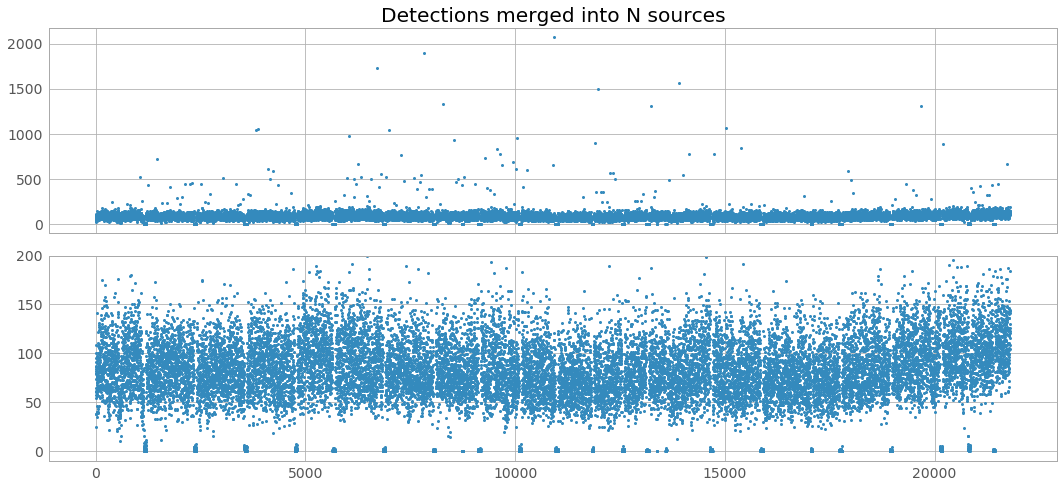

In [7]:
fig, axes = plt.subplots(2, 1, sharex=True)

a = read_merged_num("merged_num")
x = range(len(a))

[ax.scatter(x, a) for ax in axes]

axes[0].set_title("Detections merged into N sources")
axes[1].set_ylim(-10, 200)
plt.tight_layout()
print("Total N of sources: ", sum(a))

In [8]:
#a = read_num_sources("num_sources")
#plt.scatter(range(len(a)), a[:, 0])
# being the number of measured sources this is, of course, the same as detected sources.

# DiffExp-31.fits

Following similar logic that was applied to find out the reasons behind vertical white breaks I sorted the diaSrc fits files and filesizes by ascending order. The largest files are usually attributable to DiffExp-31 differenced image. 

Plotted are the `calexp-0303606_31.fits` image (left), the `calexp-0303610_31.fits` image that is used as a template (middle) and the result of the differencing `diffexp-31` (right).

Noticeable is the immediate poor quality of the original image with a strong linear feature extending vertically down the middle of the image. Additionally, brightness variations appear in the right-hand side vicinity of the vertical feature. This brightness variation undoubtedly corrupts PSF matching done between subimages resulting in a poor image subtraction where the right half of the image is much brighter.

CCD 31 seems to usually be the worst, but I can not find any particular rule. Several pointing would need to be examined to find CCD's that are constantly failing.

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/astropy/visualization/stretch.py:368: RuntimeWarning: overflow encountered in sinh
  np.sinh(values, out=values)


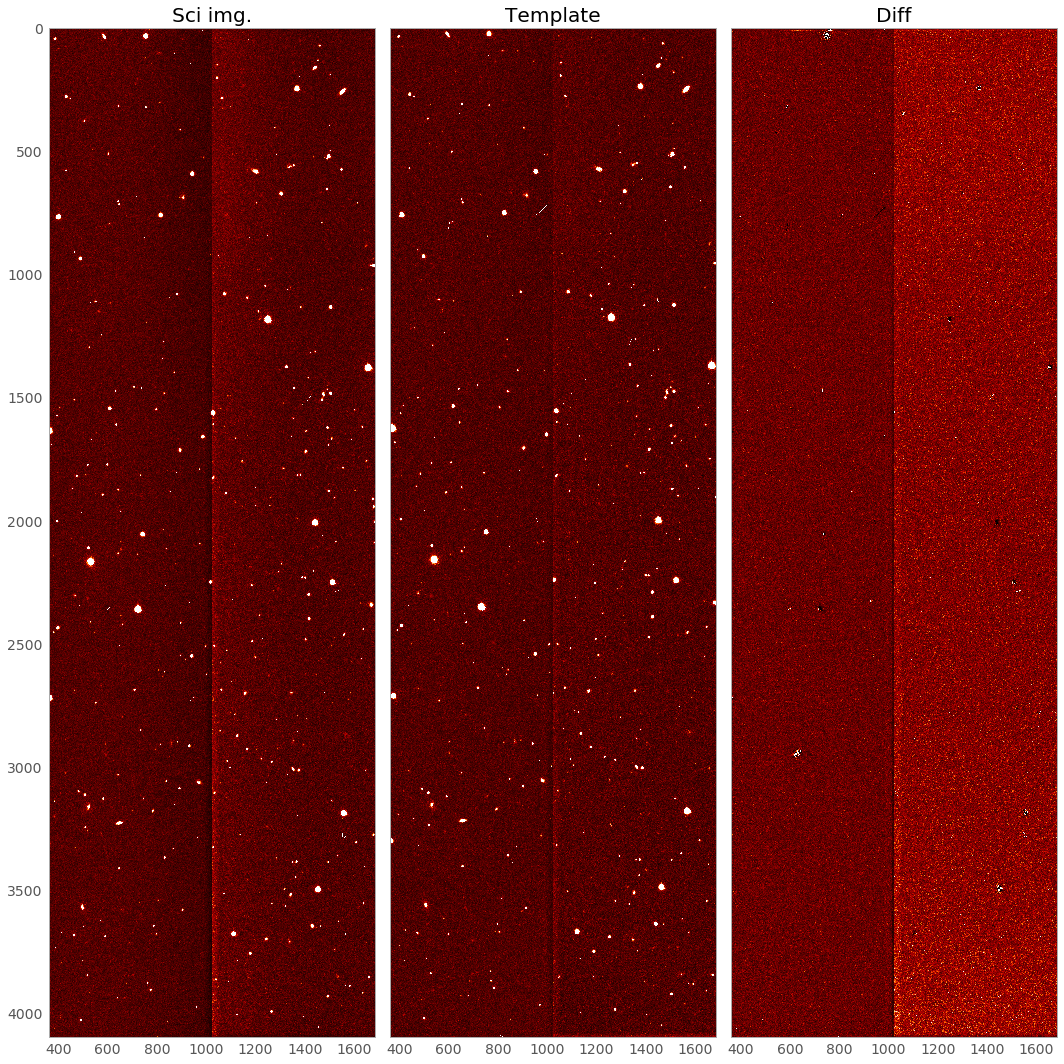

In [47]:
f1hl = fits.open(".../calexp-0303606_31.fits")
f2hl = fits.open(".../calexp-0303610_31.fits")
diff = fits.open(".../diffexp-31.fits")

def imgnorm(img):
    minv, maxv = visz.ZScaleInterval().get_limits(img)
    norm = visz.ImageNormalize(vmin=minv, vmax=maxv, stretch=visz.SinhStretch())
    return norm

norm1 = imgnorm(f1hl[1].data)
norm2 = imgnorm(f2hl[1].data)
norm3 = imgnorm(diff[1].data)

fig, axes = plt.subplots(1, 3, figsize=(15, 15), sharey=True)

axes[0].imshow(f1hl[1].data, norm=norm1)
axes[1].imshow(f2hl[1].data, norm=norm2)
axes[2].imshow(diff[1].data, norm=norm3)

axes[0].set_title("Sci img.")
axes[1].set_title("Template")
axes[2].set_title("Diff")

[ax.grid(False) for ax in axes]
plt.tight_layout()

Additionally I have overplotted all the sources found in diaSrc fits file, naively as squares with a side-length of `2*size`, to examine where most of the sources are being detected.

Unexpectedly it is not alongside the middle of the image, it is on the left-hand side. I suspect the brighter right-hand side raises the detection threshold, or changes the relevant image statistics, sufficiently for the object detection to fail.

In total there are 1894 sources detected


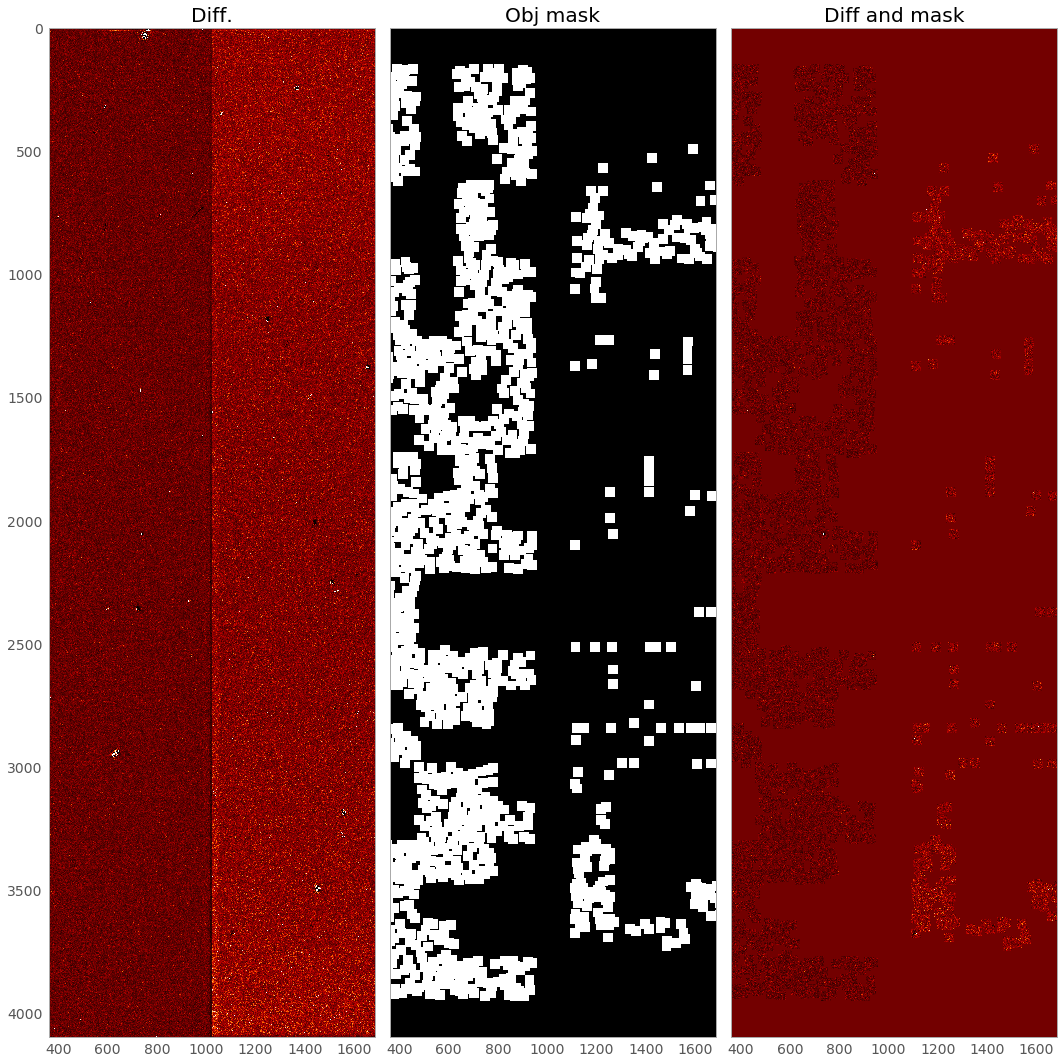

In [48]:
dias = fits.open(".../diaSrc-31.fits")
table = dias[1].data

mask = np.zeros(diff[1].data.shape)
size = 20

for x, y in zip(table.field("ip_diffim_NaiveDipoleCentroid_x"), 
                table.field("ip_diffim_NaiveDipoleCentroid_y")):
    mask[int(y)-size:int(y)+size, int(x)-size:int(x)+size] = 1.0
    
fig, axes = plt.subplots(1, 3, figsize=(15, 15), sharey=True)

axes[0].imshow(diff[1].data, norm=norm3)
axes[1].imshow(mask)
axes[2].imshow(diff[1].data*mask, norm=norm3)

axes[0].set_title("Diff.")
axes[1].set_title("Obj mask")
axes[2].set_title("Diff and mask")

[ax.grid(False) for ax in axes]
plt.tight_layout()

print("In total there are {0} sources detected".format(len(table.field("ip_diffim_NaiveDipoleCentroid_x"))))

# Scaling grid parameter

I'm not really sure what this is. I believe that when deciding on how to grid the image into sub-exposures to account for variable background (which is not assumed by default in Zogy) they compare averages(?) between areas that are some distance appart. 

For that they scale the grid by psfFWHM? (psfFWHM scaled is scaling grid parameter?)

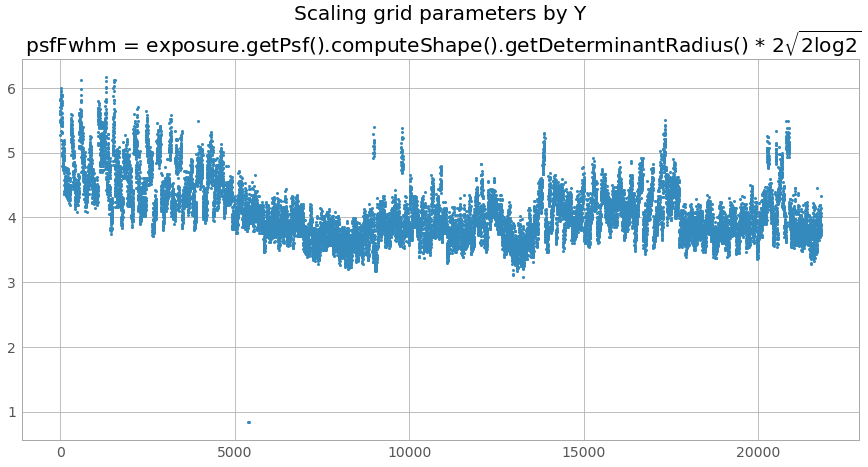

In [9]:
a = read_scalinggrid_param("scalingrid_param")
plt.title("Scaling grid parameters by Y\n psfFwhm = exposure.getPsf().computeShape().getDeterminantRadius() * $2\sqrt{2\log{2}}$")
plt.scatter(range(len(a)), a)

# Number of subimages used

Once the image is grided Zogy is applied on each subimage the grid divides the original image to. PSF's are then matched to be smooth across the boundaries of these subimages to create the final matched PSF for image differencing. The higher the number of subimages used the higher the background variability is estimated. 

In general what is expected is a smooth variation of these values across the whole night - as sky is sort of uniform. 

Appart from 1 outlier I can't figure out the rest of the images seems to follow their local trends.

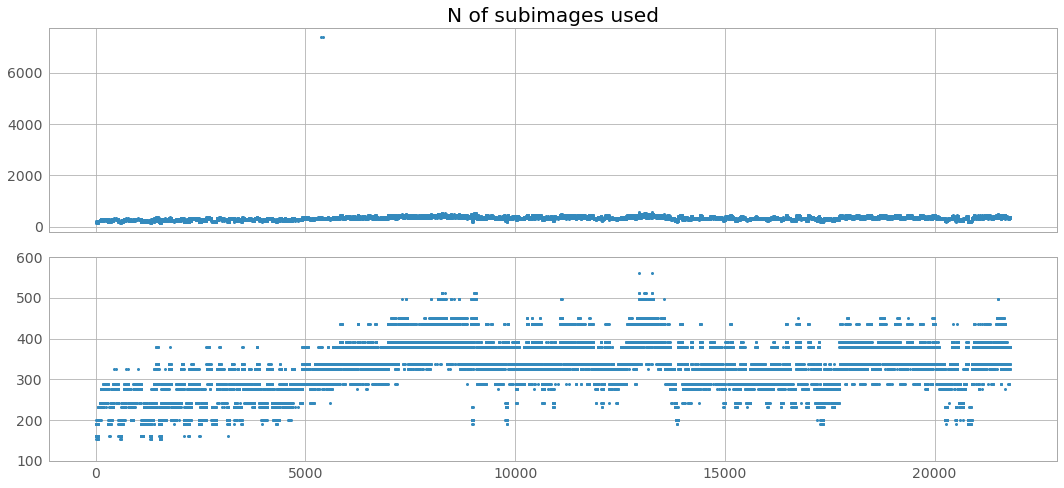

In [45]:
fig, axes = plt.subplots(2, 1, sharex=True)

a = read_subimg_num("subimg_num")
x = range(len(a))

[ax.scatter(x, a) for ax in axes]

axes[0].set_title("N of subimages used")
axes[1].set_ylim(100, 600)
plt.tight_layout()

# Overlaps 

The average (without NAN's), global maximum and global minimum of the array of weigths used during differencing. In code as:
```
weights = afwImage.ImageI(newMI.getBBox())
#.....
wts = weights.getArray().astype(np.float)
#.....
self.log.info('AVERAGE: Average overlap: %f', np.nanmean(wts))
```

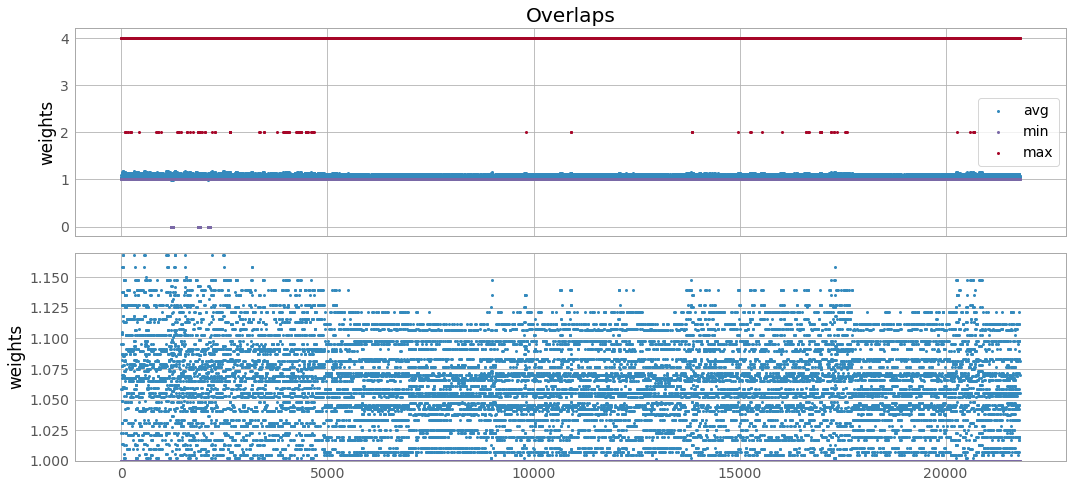

In [49]:
avg = read_overlap("avg_overlap")
minv = read_overlap("min_overlap")
maxv = read_overlap("max_overlap")

fig, axes = plt.subplots(2, 1, sharex=True)

x = range(len(avg))
[ax.scatter(x, avg, label="avg") for ax in axes]
[ax.scatter(x, minv, label="min") for ax in axes]
[ax.scatter(x, maxv, label="max") for ax in axes]

axes[1].set_ylim(1.0, 1.17)
axes[1].set_ylabel("index")
axes[1].set_ylabel("weights")
axes[0].set_title("Overlaps")
axes[0].legend()
axes[0].set_ylabel("weights")
plt.tight_layout()

# Missing data

For example: `night_1/0303707/calexp` all calexps above 53 are missing. This happens for all the fields where diaSrc fits files are only 68kb in size. So at least for the following ones:

Size| Field
---|------------------------
68|	./v303703/diaSrc-54.fits
68|	./v303703/diaSrc-56.fits
68|	./v303703/diaSrc-57.fits
68|	./v303703/diaSrc-58.fits
68|	./v303703/diaSrc-62.fits
68|	./v303723/diaSrc-05.fits
68|	./v303723/diaSrc-06.fits
68|	./v303723/diaSrc-08.fits
68|	./v303723/diaSrc-09.fits
68|	./v303723/diaSrc-10.fits
68|	./v303723/diaSrc-11.fits
68|	./v303723/diaSrc-12.fits
68|	./v303723/diaSrc-13.fits
68|	./v303723/diaSrc-14.fits
68|	./v303723/diaSrc-15.fits
68|	./v303723/diaSrc-16.fits
68|	./v303723/diaSrc-18.fits
68|	./v303723/diaSrc-19.fits
68|	./v303723/diaSrc-20.fits
68|	./v303723/diaSrc-21.fits
68|	./v303723/diaSrc-22.fits
68|	./v303723/diaSrc-25.fits
68|	./v303723/diaSrc-26.fits
68|	./v303723/diaSrc-27.fits
68|	./v303723/diaSrc-28.fits
68|	./v303723/diaSrc-29.fits
68|	./v303723/diaSrc-30.fits
68|	./v303723/diaSrc-33.fits
68|	./v303723/diaSrc-34.fits
68|	./v303723/diaSrc-35.fits
68|	./v303723/diaSrc-36.fits
68|	./v303723/diaSrc-40.fits
68|	./v303723/diaSrc-41.fits
68|	./v303723/diaSrc-42.fits
68|	./v303723/diaSrc-43.fits
68|	./v303723/diaSrc-44.fits
68|	./v303723/diaSrc-46.fits
68|	./v303783/diaSrc-01.fits
68|	./v303783/diaSrc-04.fits
68|	./v303783/diaSrc-05.fits
68|	./v303783/diaSrc-06.fits
68|	./v303783/diaSrc-07.fits
68|	./v303783/diaSrc-09.fits
68|	./v303783/diaSrc-10.fits
68|	./v303783/diaSrc-11.fits
68|	./v303783/diaSrc-12.fits
68|	./v303783/diaSrc-13.fits
68|	./v303783/diaSrc-15.fits
68|	./v303783/diaSrc-18.fits
68|	./v303783/diaSrc-19.fits
68|	./v303783/diaSrc-20.fits
68|	./v303783/diaSrc-21.fits
68|	./v303783/diaSrc-22.fits
68|	./v303783/diaSrc-23.fits
68|	./v303783/diaSrc-24.fits
68|	./v303783/diaSrc-26.fits
68|	./v303783/diaSrc-27.fits
68|	./v303783/diaSrc-28.fits
68|	./v303783/diaSrc-29.fits
68|	./v303783/diaSrc-31.fits
68|	./v303783/diaSrc-34.fits
68|	./v303783/diaSrc-35.fits
68|	./v303783/diaSrc-36.fits
68|	./v303783/diaSrc-37.fits
68|	./v303783/diaSrc-38.fits
68|	./v303783/diaSrc-41.fits
68|	./v303783/diaSrc-43.fits
68|	./v303783/diaSrc-44.fits
68|	./v303783/diaSrc-47.fits
68|	./v303783/diaSrc-48.fits
68|	./v303783/diaSrc-51.fits
68|	./v303783/diaSrc-52.fits
68|	./v303783/diaSrc-53.fits
68|	./v303783/diaSrc-54.fits
68|	./v303783/diaSrc-55.fits
68|	./v303783/diaSrc-56.fits
68|	./v303783/diaSrc-57.fits
68|	./v303783/diaSrc-58.fits
68|	./v303783/diaSrc-60.fits
68|	./v303803/diaSrc-01.fits
68|	./v303983/diaSrc-48.fits
68|	./v303983/diaSrc-49.fits
68|	./v303983/diaSrc-50.fits
68|	./v303983/diaSrc-51.fits
68|	./v303983/diaSrc-52.fits
68|	./v303983/diaSrc-59.fits

Also there are some completely full fields missing:

i| field
-|---------------------------------------------------------------------
 |root WARN: No data found for dataId=OrderedDict([('visit', 303660)])
 |root WARN: No data found for dataId=OrderedDict([('visit', 303645)])
 |root WARN: No data found for dataId=OrderedDict([('visit', 303724)])
 |root WARN: No data found for dataId=OrderedDict([('visit', 303761)])
 |root WARN: No data found for dataId=OrderedDict([('visit', 303763)])
 |root WARN: No data found for dataId=OrderedDict([('visit', 303775)])
 |root WARN: No data found for dataId=OrderedDict([('visit', 303779)])
 |root WARN: No data found for dataId=OrderedDict([('visit', 303777)])
 |root WARN: No data found for dataId=OrderedDict([('visit', 303787)])
 |root WARN: No data found for dataId=OrderedDict([('visit', 303808)])
 |root WARN: No data found for dataId=OrderedDict([('visit', 303805)])
 |root WARN: No data found for dataId=OrderedDict([('visit', 303806)])
 |root WARN: No data found for dataId=OrderedDict([('visit', 303948)])
 |root WARN: No data found for dataId=OrderedDict([('visit', 303976)])
 |root WARN: No data found for dataId=OrderedDict([('visit', 304000)])
 
 
It's unlikely that they are missing because of my job creation script - I'm not just blindly going through all the numbers in the range. I'm creating the jobs based on the matched designations from Colin's NEO_header_object file which he created by going through the headers if I understood correctly. 